# Jupyter notebook version of the line example

This example shows how to run and document a model experiment with LADiM in a jupyter notebook.

The example is modified from a notebook from Pål N. Sævik

## Imports 

In [1]:
# Basic
from io import StringIO
import numpy as np
from netCDF4 import Dataset

# Plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

# Ladim
import ladim
from postladim import ParticleFile

## Basic settings

In [2]:
# Time
start_time = '1989-05-24T12:00:00'
stop_time  = '1989-06-15T12:00:00'
# Files
input_file    = '../data/ocean_avg_0014.nc'
particle_file = 'line.nc'
release_file  = 'line.rls'
config_file   = 'ladim.yaml'

## Release file

First make a release file, initializing a line of particles

In [3]:
# End points of the line (in grid coordinates)
x0, x1 = 63.55, 123.45
y0, y1 = 90.0, 90.0

# Generate the points along the line
Npart = 1000
X = np.linspace(x0, x1, Npart)
Y = np.linspace(y0, y1, Npart)

# Particle depth
Z = 5 

release_string = StringIO()
#for x, y in zip(X, Y):
#   release_string.write(
#        f'{start_time:s} {x:7.3f} {y:7.3f} {Z:6.1f}\n')
# Write the release file
with open(release_file, mode='w', encoding='utf-8') as fid:
    for x, y in zip(X, Y):
        fid.write(f'{start_time:s} {x:7.3f} {y:7.3f} {Z:6.1f}\n')

## Config file

This file configures the numerical experiment. The text is in yaml format. Python 3.6 f-strings are used, variables in single curly braces are filled in. Double curly braces are used
to generate single braces in the yaml file.

In [4]:
yaml_text = StringIO(f"""
time_control:
    # Start and stop of simulation
    start_time : {start_time}
    stop_time  : {stop_time}

files:
    grid_file             : {input_file}
    input_file            : {input_file}
    particle_release_file : {release_file}
    output_file           : {particle_file}

state:
    # pid, X, Y, Z are mandatory and should not be given
    # ibm_variables: []

particle_release:
    variables: [release_time, X, Y, Z]
    # Converters (if not float)
    release_time: time
    particle_variables: [release_time]

gridforce:
    module: ladim.gridforce.ROMS

output_variables:
    # Output period, format [value, unit], unit = s, m, h, or d
    outper: [3, h]
    # Variable names
    particle: [release_time]
    instance: [pid, X, Y, Z]
    # NetCDF arguments
    release_time:
        ncformat: f8
        long_name: particle release time
        units: seconds since reference_time
    pid: {{ncformat: i4, long_name: particle identifier}}
    X: {{ncformat: f4, long_name: particle X-coordinate}}
    Y: {{ncformat: f4, long_name: particle Y-coordinate}}
    Z:
        ncformat: f4
        long_name: particle depth
        standard_name: depth_below_surface
        units: m
        positive: down

numerics:
    # Model time step, [value, unit]
    dt: [1, h]
    # Advection method: options =
    #        EF = Euler-Forward,
    #        RK2, RK4 = Runge-Kutta 2nd or 4th order
    advection: RK4
    # Horizontal diffusion coefficient [m2.s-1]
    #         zero = no diffusion
    diffusion: 0.0
""")

## Ladim simulation

In [5]:
ladim.main(config_stream=yaml_text, loglevel='WARNING')

##  Plot initial particle distribution

This also prepares for the following animation.

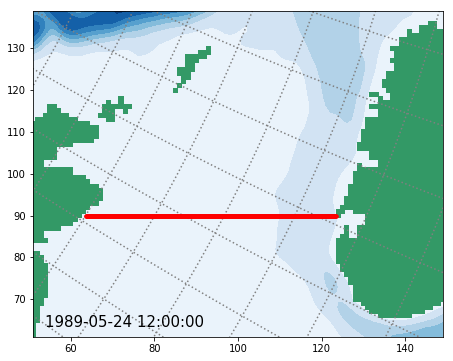

In [6]:
# Subgrid for plotting
i0, i1 = 50, 150
j0, j1 = 60, 140

# Read data for background plot
with Dataset(input_file) as ncid:
    H = ncid.variables['h'][j0:j1, i0:i1]
    M = ncid.variables['mask_rho'][j0:j1, i0:i1]
    lon = ncid.variables['lon_rho'][j0:j1, i0:i1]
    lat = ncid.variables['lat_rho'][j0:j1, i0:i1]
    
# Cell centers and boundaries
Xcell = np.arange(i0, i1)
Ycell = np.arange(j0, j1)
Xb = np.arange(i0-0.5, i1)
Yb = np.arange(j0-0.5, j1)

# particle_file
pf = ParticleFile(particle_file)

# Set up the plot area
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(xlim=(i0+1, i1-1), ylim=(j0+1, j1-1), aspect='equal')

# Background bathymetry
cmap = plt.get_cmap('Blues')
ax.contourf(Xcell, Ycell, H, cmap=cmap)

# Lon/lat lines
ax.contour(Xcell, Ycell, lat, levels=range(55, 63),
           colors='grey', linestyles=':')
ax.contour(Xcell, Ycell, lon, levels=range(-6, 10, 2),
           colors='grey', linestyles=':')

# A simple landmask from the ROMS grid
constmap = plt.matplotlib.colors.ListedColormap([0.2, 0.6, 0.4])
M = np.ma.masked_where(M > 0, M)
ax.pcolormesh(Xb, Yb, M, cmap=constmap)

# Time stamp
timestamp = ax.text(0.03, 0.03, pf.time(0), fontsize=15,
                    transform=ax.transAxes)

# Particle plot
dots, = ax.plot(X, Y, '.', color='red')

# Animation update function
def plot_dots(timestep):
    X, Y = pf.position(timestep)
    dots.set_data(X, Y)
    timestamp.set_text(pf.time(timestep))
    return dots

plot_dots(0);

## Animation 

In [7]:
anim = animation.FuncAnimation(fig, plot_dots,
    frames=pf.num_times, interval=50, repeat=False)

HTML(anim.to_html5_video())